<a href="https://colab.research.google.com/github/nabarahim/AFIB-and-MI-Correlation/blob/main/Customized_Dataset%20%2B%20Feature%20Engineering%20%2B%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier
import scipy.io.wavfile
import scipy.signal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_mitbih_train = pd.read_csv('/content/drive/MyDrive/ECG/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('/content/drive/MyDrive/ECG/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

df_ptbdb_normal = pd.read_csv('/content/drive/MyDrive/ECG/ptbdb_normal.csv', header=None)
df_ptbdb_abnormal = pd.read_csv('/content/drive/MyDrive/ECG/ptbdb_abnormal.csv', header=None)
df_ptbdb = pd.concat([df_ptbdb_normal, df_ptbdb_abnormal], axis=0)

print(df_mitbih.info())
print(df_ptbdb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14552 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 21.0 MB
None


In [ ]:
df_ptbdb.head(10)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.000000,0.487680,0.114305,0.000000,0.030116,0.065024,0.060917,0.050992,0.053388,0.051677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.000000,0.460381,0.122178,0.009296,0.125719,0.220009,0.267375,0.262948,0.260292,0.274015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.000000,0.755102,0.135116,0.000000,0.285714,0.331457,0.256861,0.258269,0.253343,0.277270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.706176,0.323144,0.101684,0.013724,0.222707,0.285714,0.295696,0.325016,0.350593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_mitbih.head(187)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1.000000,0.871486,0.325301,0.042169,0.190763,0.178715,0.100402,0.086345,0.100402,0.094378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,1.000000,0.558065,0.000000,0.103226,0.100000,0.090323,0.100000,0.077419,0.090323,0.083871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,1.000000,0.713851,0.298326,0.076104,0.000000,0.068493,0.132420,0.126332,0.114155,0.100457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,1.000000,0.662338,0.181818,0.145455,0.129870,0.111688,0.067532,0.103896,0.124675,0.137662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# ptbdb
M_ptbdb = df_ptbdb.values
X_ptbdb = M_ptbdb[:,:-1]
y_ptbdb = M_ptbdb[:,-1]

# mitbih
M_mitbih = df_mitbih.values
X_mitbih = M_mitbih[:,:-1]
y_mitbih = M_mitbih[:,-1]

KeyError: ignored

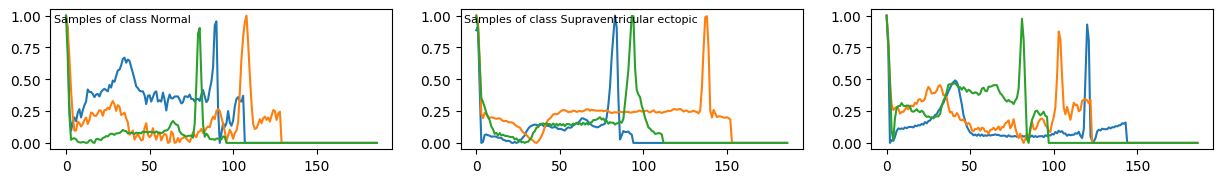

In [ ]:
classes={0:"Normal",
         1:"Supraventricular ectopic",
         3:"Ventricular ectopic beat",
         4:"Fusion beat",
         5:"Unknown beat"}
plt.figure(figsize=(15,4))
for i in range(0,5):
    plt.subplot(2,3,i + 1)
    all_samples_indexes = np.where(y_mitbih == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_mitbih[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc='left', fontdict={'fontsize':8}, x=0.01, y=0.85)

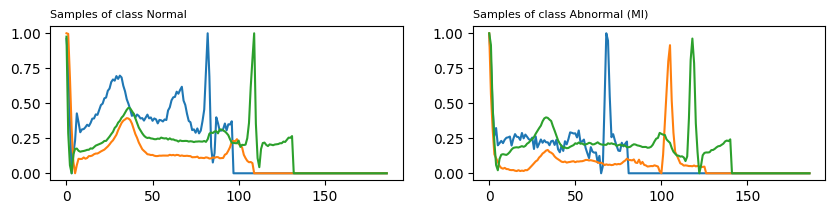

In [ ]:
classes={0:"Normal", 1:"Abnormal (MI)"}
plt.figure(figsize=(10,2))
for i in range(0,2):
    plt.subplot(1,2,i + 1)
    all_samples_indexes = np.where(y_ptbdb == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_ptbdb[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc="left", fontdict={'fontsize':8})

In [ ]:
x = np.where(df_mitbih[187]>0)
df_mitbih[187].iloc[x] = 1

repartition = df_mitbih[187].astype(int).value_counts()
print(repartition)

0    90589
1    18857
Name: 187, dtype: int64


In [ ]:
repartition1 = df_ptbdb[187].astype(int).value_counts()
print(repartition1)

1    10506
0     4046
Name: 187, dtype: int64


In [ ]:
df= pd.concat([df_ptbdb, df_mitbih], axis=0)

In [ ]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.000000,0.487680,0.114305,0.000000,0.030116,0.065024,0.060917,0.050992,0.053388,0.051677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.000000,0.460381,0.122178,0.009296,0.125719,0.220009,0.267375,0.262948,0.260292,0.274015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.000000,0.755102,0.135116,0.000000,0.285714,0.331457,0.256861,0.258269,0.253343,0.277270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.706176,0.323144,0.101684,0.013724,0.222707,0.285714,0.295696,0.325016,0.350593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
M = df.values
X = M[:,:-1]
y = M[:,-1]

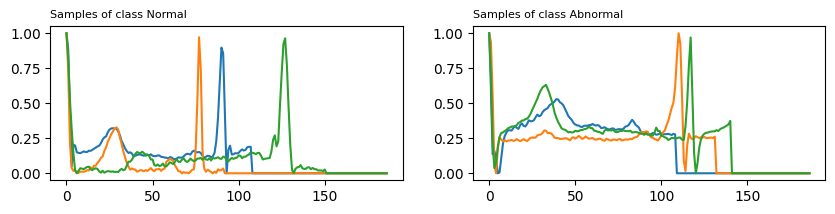

In [ ]:
classes={0:"Normal", 1:"Abnormal"}
plt.figure(figsize=(10,2))
for i in range(0,2):
    plt.subplot(1,2,i + 1)
    all_samples_indexes = np.where(y == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc="left", fontdict={'fontsize':8})

**Denosing using Butterworth**

In [ ]:
signal_df = pd.DataFrame(df)

In [ ]:
signal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Original Data')

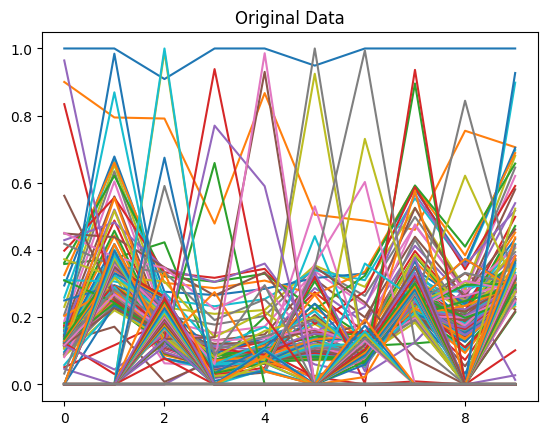

In [ ]:
plt.plot(signal_df[0:10])
plt.title('Original Data')

In [ ]:
from scipy.signal import butter, lfilter

In [ ]:
# fs = 1000  # Sampling frequency
# # Generate the time vector properly
# t = np.arange(1000) / fs

In [ ]:
from scipy.signal import filtfilt
def butter_lowpass(data,cutoff, sample_rate, order=2):
   b, a = butter_lowpass(cutoff = 2, sample_rate = 100, order = 2)
#   b, a = butter_lowpass(cutoff = 4.5, sample_rate = 12.5, order = 5)
   nyq = 0.5 * sample_rate
   normal_cutoff = cutoff / nyq
   b, a = butter(order, normal_cutoff, btype='low', analog=False)
   y = lfilter(b, a, df)
   return y

In [ ]:
fs = 50.0       # sample rate, Hz
cutoff = 3    # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 2 Hz
order = 2       # sin wave can be approx represented as quadratic
def butter_lowpass_filter(data, cutoff, fs, order):
    print("Cutoff freq " + str(cutoff))
    nyq = 0.5 * fs # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a,data)
    return y

In [ ]:
filter = butter_lowpass_filter(df, cutoff, fs, order)

Cutoff freq 3


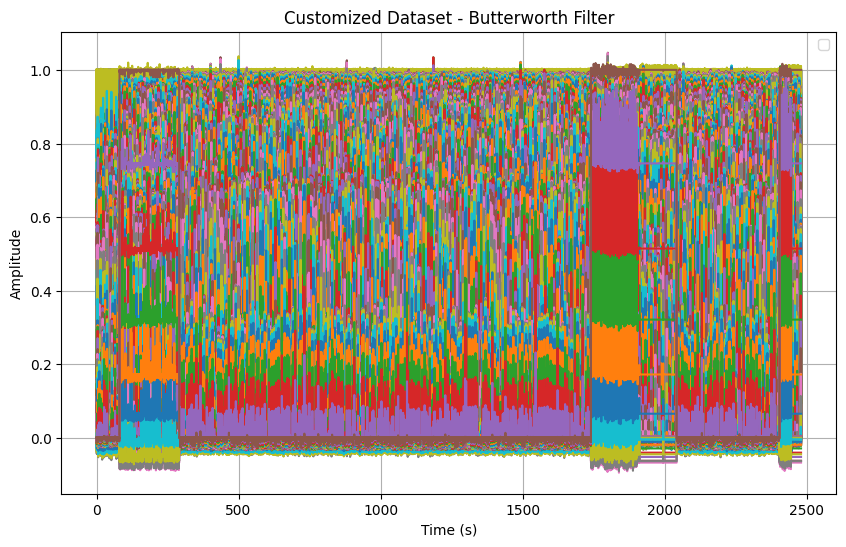

In [ ]:
# Plot the original and filtered signals
time = np.arange(len(signal_df)) / fs

plt.figure(figsize=(10, 6))
plt.plot(time, signal_df)
plt.plot(time, filter)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Customized Dataset - Butterworth Filter')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


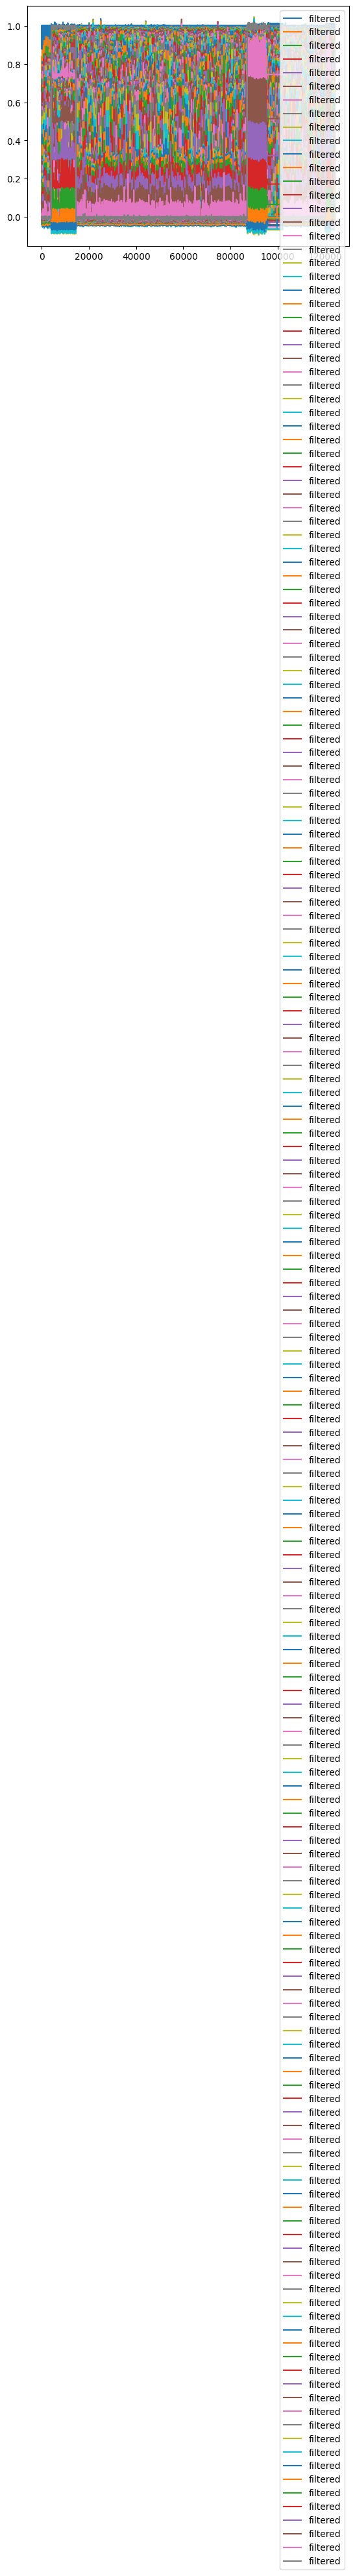

In [ ]:
plt.plot(filter,label="filtered")
plt.legend()
plt.show()

**Pan Tompkins Segment**

In [ ]:
# # Convert the dataset to a NumPy array
# data = np.array(filter)

In [ ]:
# def pan_tompkins(data):
#   """
#   Applies the Pan-Tompkins algorithm to a signal.

#   Args:
#     data: The signal to be analyzed.

#   Returns:
#     The fundamental frequency of the signal, and the times of the peaks.
#   """

#   # Define the filter coefficients
#   cutoff_frequency = 0.5
#   order = 2
#   b, a = butter(order, cutoff_frequency, btype='low')

#   # Filter the signal
#   filtered_data = lfilter(b, a, data)

#   # Apply the Hilbert transform
#   analytic_signal = scipy.signal.hilbert(filtered_data)

#   # Calculate the squared magnitude of the analytic signal
#   squared_magnitude = np.abs(analytic_signal)**2

#   # Find the peaks in the squared magnitude
#   peak_indices = np.argmax(squared_magnitude)

#   # Calculate the fundamental frequency
#   f0 = np.array([60 / (peak_indices[1] - peak_indices[0])])

#   # Return the fundamental frequency and the times of the peaks
#   return f0, peak_indices

In [ ]:
# def pan_tompkins(data):
#   """
#   Applies the Pan-Tompkins algorithm to a signal.

#   Args:
#     data: A NumPy array of the signal data.

#   Returns:
#     A tuple of the peak locations and the peak heights.
#   """

#   # Compute the first derivative of the signal.
#   ddata = np.diff(data)

#   # Compute the squared magnitude of the derivative.
#   mdata = ddata**2

#   # Compute the Hilbert transform of the squared magnitude.
#   hdata = np.imag(scipy.signal.hilbert(mdata))

#   # Compute the threshold.
#   threshold = 0.2 * np.std(hdata)

#   # Find the peaks in the Hilbert transform.
#   peaks = np.where(hdata > threshold)[0]

#   # Return the peak locations and the peak heights.
#   return peaks, hdata[peaks]

In [ ]:
# # Apply the Pan-Tompkins algorithm
# peaks, _ = pan_tompkins(data)

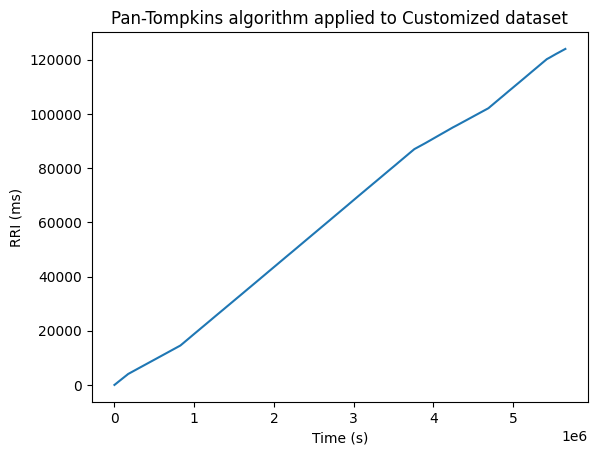

In [ ]:
# # Plot the results in wavelet signal form
# plt.figure()
# # plt.plot(data)
# plt.plot(peaks)
# plt.title('Pan-Tompkins algorithm applied to Customized dataset')
# plt.xlabel('Time (s)')
# plt.ylabel('RRI (ms)')
# plt.show()

In [ ]:
# import pywt
# # Perform wavelet transformation
# wavelet_coeffs = pywt.wavedec(peaks, wavelet='db4', level=5)

In [ ]:
# # Plot the wavelet coefficients and detected QRS complexes
# plt.figure(figsize=(10, 6))
# for i, coeffs in enumerate(wavelet_coeffs):
#     plt.plot(coeffs + i * 0.5, label='Level {}'.format(i + 1))

In [ ]:
# plt.scatter(peaks, [5] * len(peaks), marker='x', color='r', label='Detected QRS Complexes')
# plt.title('Wavelet Transform of ECG Signal with Detected QRS Complexes')
# plt.xlabel('Sample')
# plt.ylabel('Wavelet Coefficients')
# plt.legend()
# plt.tight_layout()
# plt.show()

**Min Max Normalize**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(filter)

In [ ]:
# Standardize the data
standard_scaler = StandardScaler()
standardized_data = standard_scaler.fit_transform(normalized_data)

**Feature Scaling using PCA**

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA for feature scaling
pca = PCA(n_components=2)
X_pca = pca.fit_transform(standardized_data)

**Plot all steps**

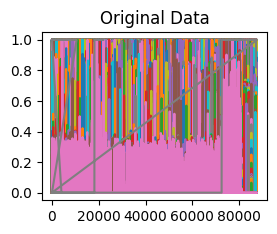

In [ ]:
import matplotlib.pyplot as plt

# Display the original data
plt.subplot(2, 2, 1)
plt.plot(df)
plt.title('Original Data')

plt.show()

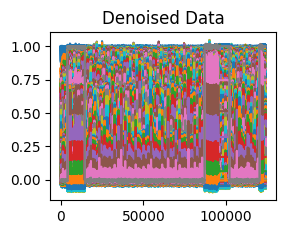

In [ ]:
# Display the denoised data
plt.subplot(2, 2, 1)
plt.plot(filter)
plt.title('Denoised Data')
plt.show()


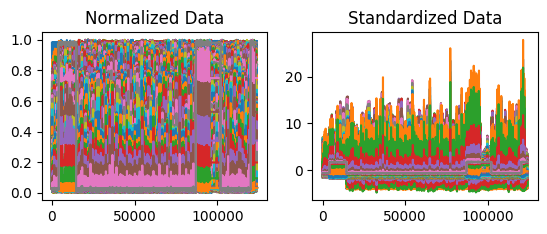

In [ ]:
# Display the normalized data
plt.subplot(2, 2, 1)
plt.plot(normalized_data)
plt.title('Normalized Data')

# Display the standardized data
plt.subplot(2, 2, 2)
plt.plot(standardized_data)
plt.title('Standardized Data')


plt.show()


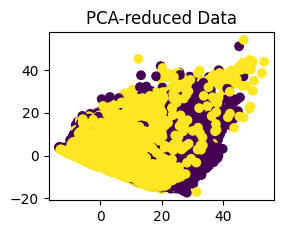

In [ ]:
# Display the PCA-reduced data
plt.subplot(2, 2, 1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.title('PCA-reduced Data')

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
X_train.shape
X_test.shape

(18600, 187)

In [ ]:
y_train.shape
y_test.shape

(18600,)

**Apply CNN**

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Activation, Add, Dense, Flatten, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
# Build the CNN model
model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(187, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(BatchNormalization())  # Add a normalization layer
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
n_classes = len(np.unique(y))

In [ ]:
print(n_classes)

2


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0007, decay_steps=10000, decay_rate=0.75)
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 185, 64)           256       
                                                                 
 conv1d_3 (Conv1D)           (None, 183, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 91, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5824)              0         
                                                                 
 dropout_1 (Dropout)         (None, 5824)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                372800    
                                                      

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),verbose=1)

Epoch 1/20
3294/3294 [==============================] - 26s 8ms/step - loss: 0.2940 - accuracy: 0.8858 - f1_score: 0.6894 - val_loss: 0.2015 - val_accuracy: 0.9263 - val_f1_score: 0.8290
Epoch 2/20
3294/3294 [==============================] - 25s 8ms/step - loss: 0.1774 - accuracy: 0.9338 - f1_score: 0.8403 - val_loss: 0.1438 - val_accuracy: 0.9451 - val_f1_score: 0.8694
Epoch 3/20
3294/3294 [==============================] - 25s 8ms/step - loss: 0.1324 - accuracy: 0.9518 - f1_score: 0.8859 - val_loss: 0.1097 - val_accuracy: 0.9625 - val_f1_score: 0.9141
Epoch 4/20
3294/3294 [==============================] - 25s 8ms/step - loss: 0.1050 - accuracy: 0.9628 - f1_score: 0.9139 - val_loss: 0.0949 - val_accuracy: 0.9684 - val_f1_score: 0.9283
Epoch 5/20
3294/3294 [==============================] - 26s 8ms/step - loss: 0.0884 - accuracy: 0.9693 - f1_score: 0.9286 - val_loss: 0.0849 - val_accuracy: 0.9724 - val_f1_score: 0.9367
Epoch 6/20
3294/3294 [==============================] - 25s 8ms/s

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
print(f"The testing set contains {counts[0]} normal recordings and {counts[1]} abnormal recordings.\nLet's compute the confusion matrix.")

The testing set contains 14132 normal recordings and 4468 with myocardial infarction.
Let's compute the confusion matrix.


In [ ]:
def plot_learning(history):
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'], label = "val_accuracy")
    plt.title('Model Accuracy')
    plt.legend(["accuracy", "val_accuracy"])
    plt.show()
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title('Model Loss')
    plt.legend(["loss", "val_loss"])
    plt.show()
    plt.subplot(211)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'], label = "val_f1_score")
    plt.title('Model F1-score')
    plt.legend(["f1_score", "val_f1_score"])
    plt.show()

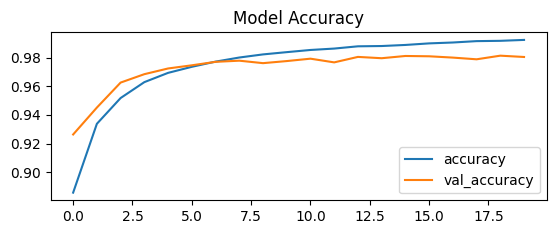

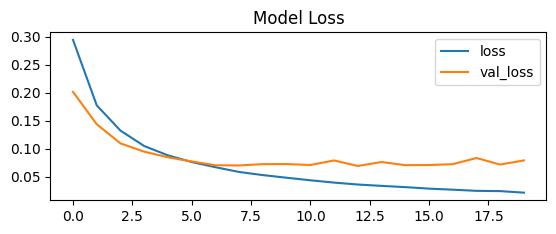

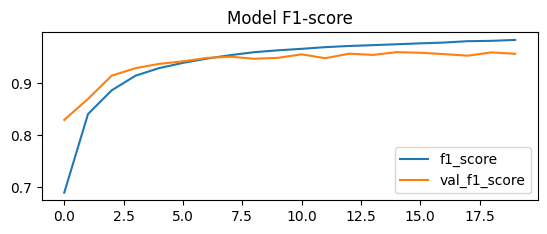

In [ ]:
plot_learning(history)

In [ ]:
results = model.evaluate(np.expand_dims(X_test, axis=2), y_test, batch_size=32)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

582/582 [==============================] - 2s 3ms/step - loss: 0.0794 - accuracy: 0.9804 - f1_score: 0.9560
The accuracy on the testing set is 98.0%
